## Importing libraries and Data Set

In [25]:
#!/usr/bin/env python

# https://dev.socrata.com/foundry/data.cityofnewyork.us/k397-673e
# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

%pip install pandas
%pip install sodapy
%pip install seaborn
%pip install matplotlib

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sodapy import Socrata
import numpy as np

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 10000000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k397-673e", limit=1000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Part I: Data Exploration

In [26]:
# Checking the type for each of the columns
# We will find that all of the columns seem to be objects so we need to convert some to numeric later on or just drop
# them if not interested in them

results_df.dtypes

fiscal_year                   object
payroll_number                object
agency_name                   object
last_name                     object
first_name                    object
mid_init                      object
agency_start_date             object
work_location_borough         object
title_description             object
leave_status_as_of_july_31    object
base_salary                   object
pay_basis                     object
regular_hours                 object
regular_gross_paid            object
ot_hours                      object
total_ot_paid                 object
total_other_pay               object
dtype: object

In [27]:
# Convert the leave_status_as_of_july_31 feature as 0 or 1


In [28]:
# Lets examine how much data we have for each of the fiscal year

unique_years = results_df['fiscal_year'].unique()
unique_years

for i in unique_years:
    print(i, ' - Number of Rows: ', results_df[results_df['fiscal_year'] == i].shape[0])


2021  - Number of Rows:  130750
2020  - Number of Rows:  128406
2019  - Number of Rows:  131457
2018  - Number of Rows:  124622
2017  - Number of Rows:  142445
2016  - Number of Rows:  116483
2015  - Number of Rows:  115347
2014  - Number of Rows:  110490


In [29]:
# Lets see how much missing data there is
# There is 17 rows that is missing the title description, 
# work_location_borough and agency_start_date which is a feature we are interested in
# Other features like payroll_number, name, mid_init we aren't interested in for this data exploration

results_df.isna().sum()



fiscal_year                        0
payroll_number                375210
agency_name                        0
last_name                        257
first_name                       259
mid_init                      479098
agency_start_date                 63
work_location_borough         109555
title_description                 17
leave_status_as_of_july_31         0
base_salary                        0
pay_basis                          0
regular_hours                      0
regular_gross_paid                 0
ot_hours                           0
total_ot_paid                      0
total_other_pay                    0
dtype: int64

#### Preprocessing
We need to convert datatypes into numerical values so that we can manipulate them and create some summary statistics and do feature engineering

In [30]:
# Drop base_salary and pay_basis since they are features that are already incorporated in regular_gross_paid
results_df = results_df.drop(columns=['base_salary', 'pay_basis'])

In [31]:

# We will also drop some rows that have mistyped 60157.150.004245.78 as the regular_gross_paid
# Using regular expression to remove strings that have more than one decimal point in them

reg_pattern = "(\.[a-z]){2,}"
filter_pattern = results_df['regular_gross_paid'].str.contains(reg_pattern)
results_df = results_df[~filter_pattern]

convert_to_numeric = ['regular_hours', 'regular_gross_paid', 'ot_hours', 'total_ot_paid', 'total_other_pay']

for i in convert_to_numeric:
    results_df[i] = pd.to_numeric(results_df[i]) 



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [32]:
# Check to see if the features have been properly converted
results_df.dtypes

fiscal_year                    object
payroll_number                 object
agency_name                    object
last_name                      object
first_name                     object
mid_init                       object
agency_start_date              object
work_location_borough          object
title_description              object
leave_status_as_of_july_31     object
regular_hours                 float64
regular_gross_paid            float64
ot_hours                      float64
total_ot_paid                 float64
total_other_pay               float64
dtype: object

In [33]:
for i in unique_years:
    print(i, ' - Number of Rows: ', results_df[results_df['fiscal_year'] == i].shape[0])

results_df.shape[0]

2021  - Number of Rows:  130750
2020  - Number of Rows:  128406
2019  - Number of Rows:  131457
2018  - Number of Rows:  124622
2017  - Number of Rows:  142445
2016  - Number of Rows:  116483
2015  - Number of Rows:  115347
2014  - Number of Rows:  110490


1000000

#### Feature Engineering
We are mostly interested in knowing total gross pay of these jobs: Regular Gross Paid + Total OT Paid + Total Other Pay.

Therefore we will make a calculated field called total_gross_pay. We also need to convert these data types to numeric since python has read them in as strings.

We can also potentially drop base_salary and pay_basis since those are implicitely included in regular_gross_paid

We can also calculate another feature called ot_paid_ per_hour from the features total_ot_paid and ot_hours. This we way we can know how much their over time pay is per hour depending on their job. Which would be an interesting thing to know.

In [34]:
# Creating a new column: total_gross_pay = regular_gross_pay + total_OT_paid + Total_Other_Pay

results_df['total_gross_pay'] = results_df['regular_gross_paid'] + results_df['total_ot_paid'] + results_df['total_other_pay']

In [38]:
# Creating a new column: ot_paid_per_hour = total_ot_paid / ot_hours
# Also removing any np.nan or np.inf due to division by 0

results_df['ot_paid_per_hour'] = results_df['total_ot_paid'] / results_df['ot_hours'] 

results_df['ot_paid_per_hour'] = results_df['total_ot_paid'].replace([np.inf, np.nan], 0)

We can use construct a covariance matrix to see the relationship between each of the numerical categories.

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


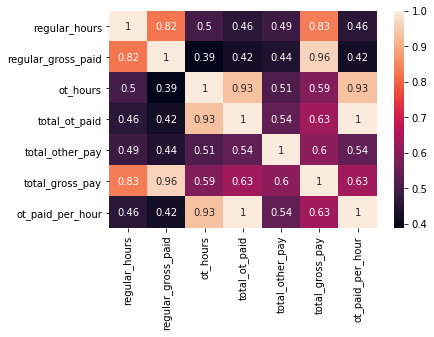

In [39]:
# Covariance Matrix
corr = results_df.corr()
sns.heatmap(corr, annot=True)


### Analysis:
Using the covariance matrix we can see some clear correlations such as the regular hours has a huge impact on regular gross paid with a high correlation of 0.82. Same goes for the correlation between total gross pay and regular gross_paid which means that the regular gross paid is pretty much included in the total gross pay. We can see that the two things that affect the total gross pay the most is the regular hours and the regular gross paid.

We can also see that this correlation matrix makes a lot of sense to our intuition since our calculated feature of ot paid per hour is almost entirely correlated to ot_hours and total_ot_paid.

## Part II: Summary Statistics

In [41]:
# Summary Statistics
results_df.describe()

,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_gross_pay,ot_paid_per_hour
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,900.131178,34303.776386,72.597479,3855.974962,2435.225805,40594.977153,3855.974962
std,892.984956,37328.754259,173.969284,10199.752878,5550.958215,45746.216175,10199.752878
min,-490.000000,-117989.060000,-209.000000,-8517.120000,-106132.000000,-117989.060000,-8517.120000
25%,0.000000,660.000000,0.000000,0.000000,0.000000,675.000000,0.000000
50%,479.500000,19888.490000,0.000000,0.000000,0.000000,20578.600000,0.000000
75%,1825.000000,63915.690000,20.000000,818.487500,2465.645000,72430.097500,818.487500
max,4171.430000,488000.000000,3347.500000,217915.940000,214703.140000,488000.000000,217915.940000


#### Analysis
If we look at the minimum for these features we can see that there are negative values which can be kinda strange to explain why total_gross_pay is negative. A couple of reasons this could happen explained here https://kb.blackbaud.com/knowledgebase/Article/49719,
however for our purposes we might want to remove these negative amounts and see how it changes our summary statistics.

In [51]:
# Lets see how many of these rows contain values where the total_gross_pay is negative (2840), we can also check which jobs these are but we'll see its not exactly specific to any one job
negative_df = results_df[results_df['total_gross_pay'] <= 0]
negative_df.shape[0]



2840

In [52]:
# Lets go ahead and just remove those rows then
positive_pay_df = results_df[results_df['total_gross_pay'] > 0]

In [53]:
positive_pay_df.describe()

,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_gross_pay,ot_paid_per_hour
count,997160.000000,997160.000000,997160.000000,997160.000000,997160.000000,9.971600e+05,997160.000000
mean,902.555059,34395.320174,72.804379,3866.932104,2456.546939,4.071880e+04,3866.932104
std,892.996074,37337.302613,174.173452,10212.191481,5482.454276,4.575081e+04,10212.191481
min,-210.000000,-18982.800000,-209.000000,-8517.120000,-106132.000000,2.842171e-14,-8517.120000
25%,0.000000,675.000000,0.000000,0.000000,0.000000,6.750000e+02,0.000000
50%,491.500000,20217.850000,0.000000,0.000000,0.000000,2.101022e+04,0.000000
75%,1825.000000,64050.100000,20.500000,839.602500,2486.400000,7.256245e+04,839.602500
max,4171.430000,488000.000000,3347.500000,217915.940000,214703.140000,4.880000e+05,217915.940000


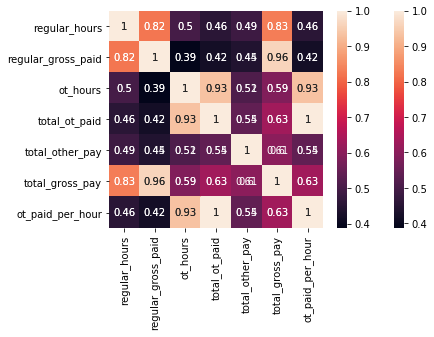

In [55]:
# Comparing the two covariance matrices
pos_corr = positive_pay_df.corr()
sns.heatmap(pos_corr, annot=True)
sns.heatmap(corr, annot=True)